### Imports

In [3]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from imblearn.over_sampling import SMOTE
import warnings

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy.stats import kurtosis, skew
from scipy import stats
from scipy.stats import randint
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from math import sqrt
from sklearn.metrics import mean_squared_error
import xgboost
from sklearn.model_selection import RandomizedSearchCV
import shap
from keras import backend as K
# from keras.engine.topology import Layer
# from keras.utils.layer_utils import get_source_inputs
from keras import initializers, regularizers, constraints

from keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.layers import Reshape, Concatenate, Lambda, Average
# from keras.layers import Reshape, merge, Concatenate, Lambda, Average
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.initializers import Constant
# from keras.layers.merge import add
import tensorflow as tf
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence

from keras.utils import to_categorical
import transformers
import torch
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
%matplotlib inline

### Loading data

In [5]:
df_products = pd.read_csv("/content/products.csv")

In [7]:
df_products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [8]:
df_products.shape

(49688, 4)

### Loading a Pre-trained Bert model with around 66M parameters

In [9]:
#bert large uncased pretrained tokenizer
pretrained_weights = 'distilbert-base-uncased'

# Load pretrained model/tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained(pretrained_weights)

In [10]:
tokenized = df_products.product_name.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [11]:
dict(zip(tokenizer.all_special_tokens,tokenizer.all_special_ids))

{'[UNK]': 100, '[SEP]': 102, '[PAD]': 0, '[CLS]': 101, '[MASK]': 103}

### Tokenizing the input

In [12]:
print(tokenized[0:2])

0        [101, 7967, 11642, 16324, 102]
1    [101, 2035, 1011, 3692, 5474, 102]
Name: product_name, dtype: object


In [13]:
#Later we will only average those tokens embeddings
text_len = [len(v) for v in tokenized]
text_len[:5]

[5, 6, 12, 14, 6]

### Limiting the maxlen to 20

In [14]:
maxlen = 20
for ix,token in enumerate(tokenized):
    if len(token) >= maxlen:
        token = token[:maxlen]
    else:
        token = token + [0] * (maxlen-len(token))
    tokenized[ix] = list(token)

In [25]:
tokenized = np.array(list(tokenized))
tokenized.shape

(49688, 20)

In [26]:
print(tokenized[0:2])

[[  101  7967 11642 16324   102     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [  101  2035  1011  3692  5474   102     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]]


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "tf_distil_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
Total params: 66362880 (253.15 MB)
Trainable params: 66362880 (253.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


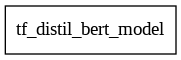

In [27]:
bert_model = transformers.TFDistilBertModel.from_pretrained(pretrained_weights)
bert_model.summary()
plot_model(bert_model)

In [28]:
product_ids = list(df_products.product_id)
product_name = list(df_products.product_name)

product_map = {}
for i in range(len(product_ids)):
    product_map[product_ids[i]] = product_name[i]

In [29]:
product_ids[:5], product_name[:5]

([1, 2, 3, 4, 5],
 ['Chocolate Sandwich Cookies',
  'All-Seasons Salt',
  'Robust Golden Unsweetened Oolong Tea',
  'Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce',
  'Green Chile Anytime Sauce'])

In [31]:
#Will compress 768 bits embedding to 768/42 = 32 bits
def compress_tokens_embedding(arr,k,step):
    output = []
    r = arr.shape[0] # No of product descriptions
    c = arr.shape[2] # Embedding size
    for i in range(r):
        tmp = [product_ids[k+i],product_name[k+i]]
        x = np.mean( np.array(arr[i])[:text_len[k+i],:], axis = 0)
        for j in range(0,c,step): #Compression
            tmp.append(np.mean(x[j:j+step]))
        output.append(tmp)
    return np.array(output)

*   Since we have 49.6K products & 49.6k * 768 dimension embedding
becomes a lot to keep in memory, we process in batches.
*   In first approach we will use the obtained hidden vector representation of all the tokens and do average pooling to get 768-dimension embedding ignoring the padded tokens.
*   We will then compress the 768-dimension embedding to 64-dimensional by pooling across dimensions.

In [33]:
input_ids = tokenized
embedding_size = 768
step = 80
k = 0
avg_bits = 12
file_counter = 0
compressed_embedding_size = embedding_size//avg_bits  #64-dimensional embedding
# with strategy.scope():
while k < input_ids.shape[0]:
    last_hidden_states = bert_model(input_ids[k:k+step])[0][:,1:maxlen+1,:] #First token to 20th (max-len) token
    output = compress_tokens_embedding(np.array(last_hidden_states),k,avg_bits)
    col = ['product_id','product_name'] + [str(v) for v in range(compressed_embedding_size)]
    df_output = pd.DataFrame(output,columns = col)
    df_output.to_csv('file_' + str(file_counter) + '.csv', header = True, index=False)
    file_counter += 1
    k += step

In [40]:
from annoy import AnnoyIndex
def create_index_find_similar_items(files):
    dfs = []
    for i in range(files):
        dfs.append(pd.read_csv('file_'+ str(i)+'.csv'))
    df_embedding = pd.concat(dfs)
    dfs.append(pd.read_csv('file_'+ str(i)+'.csv'))
    embedding_size = compressed_embedding_size
    a = AnnoyIndex(embedding_size, 'euclidean')
    for ix,row in df_embedding.iterrows():
        key = int(row['product_id'])
        vec = list(row[[str(v) for v in range(compressed_embedding_size)]])
        a.add_item(key,vec)

    a.build(100) # 100 trees
    a.save('test.tree')
    u = AnnoyIndex(embedding_size,  'euclidean')
    u.load('test.tree')

    top_k = 20
    mat = []
    for ix,row in df_embedding.iterrows():
        item = int(row['product_id'])
        mat.append([item] + u.get_nns_by_item(item, top_k+1)[1:])

#     print(len(mat),len(mat[0]))

    cols = ['product_id']
    for i in range(top_k):
        cols += ['nearest_{}'.format(i+1)]
    print(cols)

    df_neighbors1 = pd.DataFrame(mat, columns = cols)

    df_neighbors2 = df_neighbors1.copy()

    for c in cols:
        df_neighbors2[c] = df_neighbors2[c].apply(lambda v : product_map[v])

    return df_neighbors2

In [41]:
df_neighbors = create_index_find_similar_items(files= 622)

['product_id', 'nearest_1', 'nearest_2', 'nearest_3', 'nearest_4', 'nearest_5', 'nearest_6', 'nearest_7', 'nearest_8', 'nearest_9', 'nearest_10', 'nearest_11', 'nearest_12', 'nearest_13', 'nearest_14', 'nearest_15', 'nearest_16', 'nearest_17', 'nearest_18', 'nearest_19', 'nearest_20']


In [42]:
df_neighbors.head(20)

,product_id,nearest_1,nearest_2,nearest_3,nearest_4,nearest_5,nearest_6,nearest_7,nearest_8,nearest_9,...,nearest_11,nearest_12,nearest_13,nearest_14,nearest_15,nearest_16,nearest_17,nearest_18,nearest_19,nearest_20
0,Chocolate Sandwich Cookies,Chocolate Butter Cookies,Chocolate Chunk Cookies,Chocolate Chip Cookies,Chocolate Cookies,Cinnamon Bun Sandwich Cookies,Mini Chocolate Chunk Cookies,Chocolate Chip Mini Cookies,Pure Chocolate Cookies,Lemon Butter Cookies,...,Chocolate Cupcakes,Carrot Cake Cookies,Chocolate Chunk Cookie Dough,Sugar Free Chocolate Chunk Cookies,Double Chocolate Mini Cakes,Chocolate Chip Cookie Dough,Chocolate Alphabet Cookies,Mini Chocolate Chip Cookies,Cheese Cracker Sandwiches,Milk Chocolate Chips
1,All-Seasons Salt,Red Jr. Shot Glass,"Bars, Blueberry","Pizza, Cheese & Pesto","Candle, Meadows & Rain","Ice Cream, Cookies & Cream","Mustard, Stout & Stoneground","Syrup, Maple Creme","Baking Mix, Brownie","Burrito, Steak & Cheese",...,Pancakes Blueberry - 18 CT,Green Tea K-Cups,Island Vanilla Roll-On Perfume,"Gum, Peppermint",Lip Shimmer - Plum,Bite-Size Honey Gold Potatoes,"Protein Shake, Cookies & Cream","Nut Bar, Chocolate Chunk",Temptations Cat Treats - Creamy Dairy,Lemon-Lime Fridge Pack Soda
2,Robust Golden Unsweetened Oolong Tea,Natural Hibiscus Full Leaf Loose Herb Tea,Natural Vanilla Miniature Marshmallows,Organic Echinacea Plus Elderberry Tea,Organic Mekong Flower Brown Jasmine Rice,Asian Ginseng Liquid Herbal Extract,Jasmine Petal Whole Leaf Green Tea,Berry Pomegranate Liquid Water Enhancer,All Natural Lavender Sage Deodorant,Pure Seedless Marion Blackberry Preserves,...,Garden Herb Triscuit Crackers,Red Honeysuckle Nectar Scented Candle,Vanilla Mint Moisturizing Conditioner,Pure Seedless Pacific Mountain Strawberry Pres...,All Natural Raspberry Sorbet,Blue Eucalyptus & Lavender Natural Laundry Det...,California Seedless Raisins,Organic Mixed Berry Thirst Quencher,Echinacea & Elderberry Organic Herbal Tea,Organic Blueberry Mint Kombucha
3,Smart Ones Classic Favorites Mini Rigatoni Wit...,Smart Ones Tasty American Favorites Tuna Noodl...,Smart Ones Classic Favorites Chicken Enchilada...,Baby Romaine Lettuce Leaf Mix Salad Clamshell,Yokids Organic Strawberry Banana Lowfat Yogurt...,Petite Creme Lowfat Blueberry Yogurt,Sparkling Limeade with Strawberry & Lychee Vie...,Clif Kid ZBar Organic Iced Lemon Cookie Energy...,PRO Alphonso Mango Lassi Yogurt Drink,Strawberry Banana Peach Light & Fit Nonfat Yogurt,...,YoKids Squeeze Organic Blueberry Blue Yogurt,Refreshers Strawberry Lemonade Sparkling Green...,Original Strawberry/Harvest Peach Variety Pack...,Light & Fit Greek Crunch Yogurt Peanut Butter ...,Original Strawberry/Strawberry Banana Variety ...,Organic Petite Creme Mon Cherry Amour Yogurt,Berry Lemonade with Chia Chewy Granola Bars,Cherry Vanilla Creme Zero Calorie Stevia Soda,The Purple Edition Sugarfree Acai Berry Energy...,Warm & Crunchy Cranberry Almond Granola
4,Green Chile Anytime Sauce,Rustic Tomato Vodka Sauce,Hot Insanity Sauce,Mild Taco Sauce,Zesty Cocktail Sauce,Honey Barbecue Sauce,Tomato Basil Sauce,La Vodka Cooking Sauce,Mild Barbecue Sauce,Apple Strawberry Sauce,...,La Vodka Pasta Sauce,Apple Peach Sauce,Tomato Cream Sauce,Roasted Garlic Pasta Sauce,Peppercorn Sauce,Sweet Honey Barbecue Sauce,Mild Korma Simmer Sauce,Orange Chicken Sauce,Yogurt Mint Sauce,Tomato Sauce
5,Dry Nose Oil,Mild Baby Oil,Facial Oil,Beef Broth Concentrate,Fish Oil,Chicken Broth Liquid Concentrate,Organic Veggie Ground,Canola Oil,Thin Whole Grain Cakes,Chunk Light in Oil Tuna,...,Lightly Salted Peanuts,Mild Curry Paste,Organic Silken Tofu,Wheat Sandwich Thins,Vegetable Oil,Lightly Salted Peanut,Sweetened Condensed Milk,Organic Broth Ramen,Instant Nonfat Dry Milk,Skin Oil
6,Pure Coconut Water With Orange,Pure Coconut Water With Pulp,Pure Coconut Water with Pineapple,Pure Coconut Water,Organic Dark Cacao Raw Coconut Water,Pure Coconut Water with Tropical Fruit,Pure Organic Coconut Water,Organic Coconut Water Wi

In [43]:
df_neighbors.to_csv('neighbors_token_embedding_avg_compressed.csv', index=False, header=True)

In [44]:
#Will compress 768 bits embedding to 768/42 = 32 bits
def compress_cls_embedding(arr,k,step):
    output = []
    r = arr.shape[0] # No of product descriptions
    c = arr.shape[2] # Embedding size
    for i in range(r):
        tmp = [product_ids[k+i],product_name[k+i]]
        x = np.array(list(arr[i,0,:]))
        for j in range(0,c,step):
            tmp.append(np.mean(x[j:j+step]))
        output.append(tmp)
    return np.array(output)

* Since we have 49.6K products & 49.6k * 768 dimension embedding becomes to much to keep in memory, we process in batches.
* In second approach we will directly use the obtained hidden vector representation of the class-label.
* We will compress the 768-dimension embedding to 64-dimensional by possling across dimensions.

In [45]:
input_ids = tokenized
embedding_size = 768
step = 80
k = 0
avg_bits = 12
file_counter = 0
compressed_embedding_size = embedding_size//avg_bits
# with strategy.scope():
while k < input_ids.shape[0]:
    last_hidden_states = bert_model(input_ids[k:k+step])[0][:,:1,:]
    output = compress_cls_embedding(np.array(last_hidden_states),k,avg_bits)
    col = ['product_id','product_name'] + [str(v) for v in range(compressed_embedding_size)]
    df_output = pd.DataFrame(output,columns = col)
    df_output.to_csv('file_' + str(file_counter) + '.csv', header = True, index=False)
    file_counter += 1
    k += step

In [46]:
df_neighbors_cls = create_index_find_similar_items(files= 622)
df_neighbors_cls.head(20)

['product_id', 'nearest_1', 'nearest_2', 'nearest_3', 'nearest_4', 'nearest_5', 'nearest_6', 'nearest_7', 'nearest_8', 'nearest_9', 'nearest_10', 'nearest_11', 'nearest_12', 'nearest_13', 'nearest_14', 'nearest_15', 'nearest_16', 'nearest_17', 'nearest_18', 'nearest_19', 'nearest_20']


,product_id,nearest_1,nearest_2,nearest_3,nearest_4,nearest_5,nearest_6,nearest_7,nearest_8,nearest_9,...,nearest_11,nearest_12,nearest_13,nearest_14,nearest_15,nearest_16,nearest_17,nearest_18,nearest_19,nearest_20
0,Chocolate Sandwich Cookies,Chocolate Butter Cookies,Chocolate Chunk Cookies,Chocolate Chip Cookies,Chocolate Cookies,Cinnamon Bun Sandwich Cookies,Mini Chocolate Chunk Cookies,Chocolate Chip Mini Cookies,Pure Chocolate Cookies,Lemon Butter Cookies,...,Chocolate Cupcakes,Carrot Cake Cookies,Chocolate Chunk Cookie Dough,Sugar Free Chocolate Chunk Cookies,Double Chocolate Mini Cakes,Chocolate Chip Cookie Dough,Chocolate Alphabet Cookies,Mini Chocolate Chip Cookies,Cheese Cracker Sandwiches,Milk Chocolate Chips
1,All-Seasons Salt,Red Jr. Shot Glass,"Bars, Blueberry","Pizza, Cheese & Pesto","Candle, Meadows & Rain","Ice Cream, Cookies & Cream","Mustard, Stout & Stoneground","Syrup, Maple Creme","Baking Mix, Brownie","Burrito, Steak & Cheese",...,Pancakes Blueberry - 18 CT,Green Tea K-Cups,Island Vanilla Roll-On Perfume,"Gum, Peppermint",Lip Shimmer - Plum,Bite-Size Honey Gold Potatoes,"Protein Shake, Cookies & Cream","Nut Bar, Chocolate Chunk",Temptations Cat Treats - Creamy Dairy,Lemon-Lime Fridge Pack Soda
2,Robust Golden Unsweetened Oolong Tea,Natural Hibiscus Full Leaf Loose Herb Tea,Natural Vanilla Miniature Marshmallows,Organic Echinacea Plus Elderberry Tea,Organic Mekong Flower Brown Jasmine Rice,Asian Ginseng Liquid Herbal Extract,Jasmine Petal Whole Leaf Green Tea,Berry Pomegranate Liquid Water Enhancer,All Natural Lavender Sage Deodorant,Pure Seedless Marion Blackberry Preserves,...,Garden Herb Triscuit Crackers,Red Honeysuckle Nectar Scented Candle,Vanilla Mint Moisturizing Conditioner,Pure Seedless Pacific Mountain Strawberry Pres...,All Natural Raspberry Sorbet,Blue Eucalyptus & Lavender Natural Laundry Det...,California Seedless Raisins,Organic Mixed Berry Thirst Quencher,Echinacea & Elderberry Organic Herbal Tea,Organic Blueberry Mint Kombucha
3,Smart Ones Classic Favorites Mini Rigatoni Wit...,Smart Ones Tasty American Favorites Tuna Noodl...,Smart Ones Classic Favorites Chicken Enchilada...,Baby Romaine Lettuce Leaf Mix Salad Clamshell,Yokids Organic Strawberry Banana Lowfat Yogurt...,Petite Creme Lowfat Blueberry Yogurt,Sparkling Limeade with Strawberry & Lychee Vie...,Clif Kid ZBar Organic Iced Lemon Cookie Energy...,PRO Alphonso Mango Lassi Yogurt Drink,Strawberry Banana Peach Light & Fit Nonfat Yogurt,...,YoKids Squeeze Organic Blueberry Blue Yogurt,Refreshers Strawberry Lemonade Sparkling Green...,Original Strawberry/Harvest Peach Variety Pack...,Light & Fit Greek Crunch Yogurt Peanut Butter ...,Original Strawberry/Strawberry Banana Variety ...,Organic Petite Creme Mon Cherry Amour Yogurt,Berry Lemonade with Chia Chewy Granola Bars,Cherry Vanilla Creme Zero Calorie Stevia Soda,The Purple Edition Sugarfree Acai Berry Energy...,Warm & Crunchy Cranberry Almond Granola
4,Green Chile Anytime Sauce,Rustic Tomato Vodka Sauce,Hot Insanity Sauce,Mild Taco Sauce,Zesty Cocktail Sauce,Honey Barbecue Sauce,Tomato Basil Sauce,La Vodka Cooking Sauce,Mild Barbecue Sauce,Apple Strawberry Sauce,...,La Vodka Pasta Sauce,Apple Peach Sauce,Tomato Cream Sauce,Roasted Garlic Pasta Sauce,Peppercorn Sauce,Sweet Honey Barbecue Sauce,Mild Korma Simmer Sauce,Orange Chicken Sauce,Yogurt Mint Sauce,Tomato Sauce
5,Dry Nose Oil,Mild Baby Oil,Facial Oil,Beef Broth Concentrate,Fish Oil,Chicken Broth Liquid Concentrate,Organic Veggie Ground,Canola Oil,Thin Whole Grain Cakes,Chunk Light in Oil Tuna,...,Lightly Salted Peanuts,Mild Curry Paste,Organic Silken Tofu,Wheat Sandwich Thins,Vegetable Oil,Lightly Salted Peanut,Sweetened Condensed Milk,Organic Broth Ramen,Instant Nonfat Dry Milk,Skin Oil
6,Pure Coconut Water With Orange,Pure Coconut Water With Pulp,Pure Coconut Water with Pineapple,Pure Coconut Water,Organic Dark Cacao Raw Coconut Water,Pure Coconut Water with Tropical Fruit,Pure Organic Coconut Water,Organic Coconut Water Wi

In [47]:
df_neighbors_cls.to_csv('neighbors_cls_embedding_compressed.csv', index=False, header=True)

* It seems token vectors averaged & compressed seems to yield better embeddings than using the class vectors compressed, qualitatively taking into account the context even better but hard to decide the winner.
* We can also come up with a measure to evaluate the embeddings quality, like checking how many times the neigbor also belongs to same department or aisle etc.